# Analytics for "valid" runs

### Imports


In [6]:
import numpy as np       # operations on numerical arrays
import math as m
import operator          # for sorting list of class instances
from scipy import stats
import datetime as dt
from   dateutil import parser 


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

from IPython.display import display, Markdown, Latex

import runData as rd



### Classes

### Data Reading and Validation


In [7]:
nruns = 0
allruns = []
runs = []     # "valid" runs
runs3k = []
runs5k = []
routed = {}   # routes by id #

nvr = 0 # number of valid runs
nrt = 0 # number of routes

runs1 = rd.runLists()
runs1.reader()  # get the data

nruns   = runs1.nruns
allruns = runs1.allruns
runs    = runs1.runs
runs3k  = runs1.runs3k
runs5k  = runs1.runs5k
routed  = runs1.routed

nvr     = runs1.nvr
nrt     = runs1.nrt


In [8]:
# select from most pop routes
poproutes = []
for r in routed.keys():
    rt = routed[r]
    if rt.n > 5:
        poproutes.append(rt)
        
poproutes.sort(key=operator.attrgetter('n'),reverse=True)
i=0
for rt in poproutes:
    print ('{:3} {:4} {}'.format(i, rt.n, rt.name))
    i+= 1
    
sr = int(input('Select a route: '))
print ('You selected: {}'.format(poproutes[sr].name))


  0  263 Reservoir Basic
  1  221 Greenlake 3k
  2   83 no lights local loop
  3   58 Pettis Loop2 (Mtn View)
  4   53 45th to 65th loop
  5   42 Greenlake out-and-back 5k
  6   34 Greenlake 5k
  7   31 Reservoir 5k
  8   24 Latona Loop corrected
  9   20 Upper Reservoir Park
 10   17 LDS Loop
 11   16 Los Altos2
 12   15 Greenlake out & around
 13   14 Greenlake out-and-back 5k (deprecated)
 14   13 Pettis Loop 5K
 15    6 Rihely Pl / Encinitas
 16    6 New MTV 5k


Select a route:  10


You selected: LDS Loop


### plotting histogram

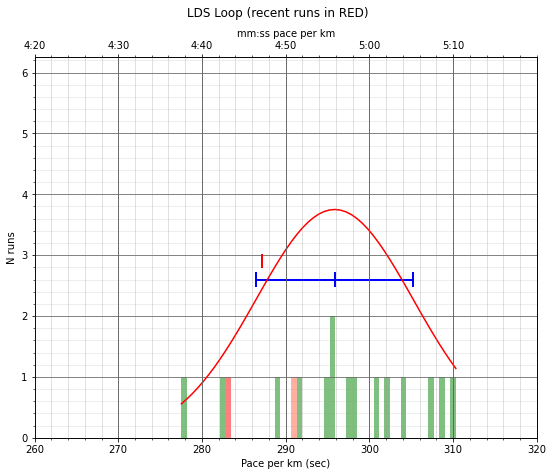

In [9]:
#print('got here...')    
r = poproutes[sr]
r.avg() # compute some averages
l = len(r.times) # times have been converted already to pace-300
ymax = np.max([5,(int(l)*0.10/5) * 5]) # auto scale y-axis

#plt.figure(1,figsize=(8,8),dpi=200)
plt.figure(1,figsize=(9,7))
 
colors = ['green', 'tomato', 'r']
onecolor = ['green']
pctile = 0.15 # this fraction of most recent runs will be in red
BIG_NEG_FLAG = -1000000
recent_mean = BIG_NEG_FLAG  # absurd flag value
# change color for most recent pctile% of runs
d0=d1=d2=[]
if(int(pctile*l) > 1):
    #  NOTE: runs are listed most RECENT first
    # break the runs up into 1) most recent run 2) most recent 15%, 3) rest
    n1 = int((pctile)*l)  # first 1-p % runs
    d0.append(r.times[0])  # most recent
    d1 = (r.times[1:(n1)])  # next most recent runs
    d2 = (r.times[n1:])  # rest
    n, bins, patches = plt.hist([d2,d1,d0], 50,color=colors,stacked=True,alpha=0.5)
    recent_mean = float(np.sum(d1)+np.sum(d0))/(n1)
    #print "Sum: ", np.sum(d1)
    plt.suptitle(r.name + " (recent runs in RED)")
else: # plain old boring histogram
    d1 = (r.times[:])
    #for j in range(0, len(d1)):  # shift times down so relative to 5:00
        #d1[j] -= 300  # 300 seconds
    n, bins, patches = plt.hist(d1, 50,color=onecolor,alpha=0.5)
    plt.title(r.name)
plt.xlabel('time (sec)')
nruns = len(r.times)


#
#  make a horizontal bar for mean and += 1 SD
#
xl = [r.avg_pace - r.sd_pace,r.avg_pace - r.sd_pace, r.avg_pace, r.avg_pace, r.avg_pace + r.sd_pace, r.avg_pace + r.sd_pace, r.avg_pace - r.sd_pace, r.avg_pace + r.sd_pace]
#for j in range(0,len(xl)):
    #xl[j] -= 300   # subtract off 5:00 pace
b1 = ymax * 0.5   # partway up the Y-axis
tick = ymax/25.0
b2 = b1+tick
b3 = b2+tick/2
b4 = b3+tick
b = (b1+b2)/2
yl = [ b1,b2,b1,b2,b1,b2,b,b]
for i in [0,2,4,6]:
    x = [xl[i], xl[i+1]]
    y = [yl[i], yl[i+1]]
    plt.plot(x,y, linewidth= 2.0, alpha= 1.0,color='blue')
# plot a tick mark for mean of most recent runs (if applicable)
if(recent_mean > BIG_NEG_FLAG):
    x = recent_mean
    plt.plot([x,x],[b3, b4],linewidth=2.0, color='red')

# plot the normal distribution
nd = stats.norm.pdf(bins, r.avg_pace, r.sd_pace)
y = 0.75*ymax*nd/np.max(nd)   #auto scale height of normal dist.
plt.plot(bins, y, 'r')

xmin = 260
xmax = 320 


#
#  plot a 'secondary' x-axis for the mm:ss representation 
#
def sec2mmss(s):
    return dt.timedelta(seconds=s)
#def mmss2sec(td):
    #return td.total_seconds()

ax1 = plt.gca()
ax2 = ax1.twiny()
#ax2.set_xlim(ax1.get_xlim())
mmss_tick_locs = [xmin+ 10*i for i in range(int((xmax-xmin)/10))]
mmss_tick_labs = [str(sec2mmss(s))[3:] for s in mmss_tick_locs]
ax2.set_xticks(mmss_tick_locs)
ax2.set_xticklabels(mmss_tick_labs)
ax2.set_xlabel('mm:ss pace per km')
ax1.set_ylabel('N runs')
ax1.set_xlabel('Pace per km (sec)')        
#
# set up axis parameters
#
for axis in [ax1, ax2]:
    # Show the major grid lines with dark grey lines
    axis.grid(b=True, which='major', color='#666666', linestyle='-')

    # Show the minor grid lines with very faint and almost transparent grey lines
    axis.minorticks_on()
    #plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axis.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    axis.set_xlim([xmin,xmax])
    axis.set_ylim([0, 1.25*ymax])
plt.show()


### Plotting Time series

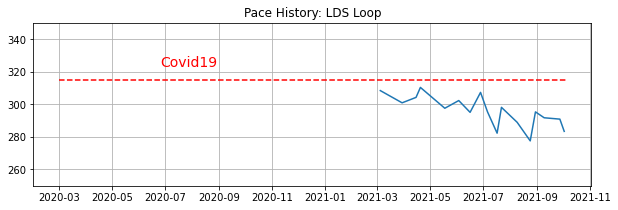

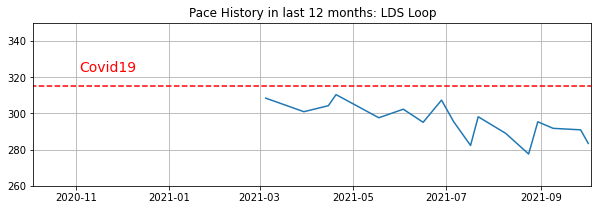

In [10]:
    ##############################################   Plot Pace vs Time
    # plt.figure(2,figsize=(10,6),dpi=200)
    plt.figure(2,figsize=(10,3))
    plt.plot(r.dates, r.times)
    # since data is most recent first, smooth a reversed array:
    rtimes = list(r.times)   #python3: convert to r.times.copy()
    rtimes.reverse() # in place
    revtimes = np.array(rtimes)
    Nsm = 15   # of smoothing points
    if Nsm%2 != 1:
        print('Smoothing windown must be odd! (fixing: Nsm={:})'.format(Nsm))
        Nsm += 1
    if len(rtimes) > 2*Nsm:
        sm = np.flip(rd.smooth(revtimes, Nsm, 'flat'),0) # flip = unreverse to match most-recent-first
        #fix glitch in last (most recent) pt 
        # try to shift smoothed for better match
        sm[0] = sm[1]  # HACK ??  
        shift = int((Nsm-1)/2)
        prefix = np.array([sm[0]]*shift)  #extend most recent complete value to present
        sm1 = np.concatenate((prefix,(sm.copy()[:-shift])))
        plt.plot(r.dates, sm1)   # moving average line
        plt.title('Pace History with 15 run moving avg.: '+r.name)
    else:
        plt.title('Pace History: '+ r.name)
    plt.grid([1,1])
    plt.ylim([250,350])
    
    ###  add a COVID BAR
    cbY = 315
    cbXmin=parser.parse('1-mar-2020').date()
    cbXmax=parser.parse('1-mar-2021')
    cbXmax=dt.date.today()  # Until further notice!!!
    a = [cbXmin, cbXmax]
    b = [cbY,cbY]
    plt.plot(a,b,color='r',linestyle='--')  # covid-19 bar
    doffst = 0.4*(cbXmax-cbXmin)/2
    txt_X = cbXmin+doffst
    plt.gca().text(txt_X, cbY*1.025, "Covid19",color='r',fontsize=14)

    plt.show()
    
    # just the last year
    dmax = dt.date.today()
    dmin = dmax - dt.timedelta(days=365)
    plt.figure(3,figsize=(10,3))
    plt.title('Pace History in last 12 months: '+r.name)
    plt.plot(r.dates,r.times) 
    plt.plot(a,b,color='r',linestyle='--')  # covid-19 bar
    xt = max(dmin,txt_X)+dt.timedelta(days=30)
    plt.gca().text(xt, cbY*1.025, "Covid19",color='r',fontsize=14)
    if len(rtimes) > 20:
        plt.plot(r.dates, sm1)   # moving average line
    plt.xlim([dmin,dmax])
    plt.ylim([260,350])
    plt.grid([1,1])
    plt.show()